The adage "a picture is worth a thousand words" is very true in the world of science (but not so true that it changes your
thesis word-count!).  A good figure that clearly articulates your data will make your work much better. Simple is good,
but your figures still need to cover the basics of being well-labeled and accurate. Plots are also extremely useful
when exploring your data - quickly plotting a few lines and seeing whether they look "right" can save you all sorts of
tedious work working out where you went wrong.

Frequently you will want to make the same, or a very similar plot multiple times.  You could do this interactively in
a spreadsheet, wasting your life away, making mistakes... (remember **DRY**), or you could write a little program
to make your plots for you!

In Python, the main plotting package is [matplotlib](https://matplotlib.org/). In this notebook we will introduce some
of the basics of data plotting, using some New Zealand GNSS (Global Navigation Satellite System) data.

To cover:
1. Line plots
2. Scatter plots
3. Labels, legends and headings
4. Colour control

In [1]:
%matplotlib inline

We will first write a function to get the data we want from GeoNet.  Note that I have adapted this from 
[the GeoNet tutorial](https://github.com/GeoNet/data-tutorials/blob/master/GNSS_Data/Python/Introduction_to_GNSS_data_using_FITS_in_Python.ipynb).

In [2]:
import requests  # This helps with web-requests
import datetime  # Python's representation of dates and times.

# I am using a Python 3 feature where you can provide hints
# for the expected type of arguments. These are not interpreted
# by the code, but just help us see what we should be giving the
# function, and what we should expect in return. You don't have
# to do this, but I like it.
def get_gnss_for_station(
    station: str, 
    fits_url: str = "http://fits.geonet.org.nz/observation",
) -> dict:
    """
    Get GNSS data from GeoNet for the station
    
    Parameters
    ----------
    station
        The name of the station you want to get data for
    fits_url
        URL of the FITS data service you want to query.
        
    Returns
    -------
    Dictionary with keys:
        time 
            list of timestamps of observations
        north
            list of offsets in mm in the north direction
        east
            list of offsets in mm in the east direction
        up          
            list of vertical offsets in mm
        north_error
            list of errors in mm for north
        east_error
            list of errors in mm for east
        up_error
            list of erros in mm for up
    
    Note: A dictionary isn't the best thing for this, a
    pandas dataframe would be better! See a later notebook
    for an intro to pandas
    """
    # Initialise an empty dictionary that we will append to
    out = dict(
        time=[], north=[], east=[], up=[], north_error=[],
        east_error=[], up_error=[])
    for channel in {"north", "east", "up"}:
        parameters = {"typeID": channel[0], "siteID": station}
        response = requests.get(fits_url, params=parameters)
        assert response.status_code == 200, "Bad request"
        payload = response.content.decode("utf-8").split("\n")
        # payload is a csv with header
        # This is a list-comprehension, a type of fast, one-line for loop
        payload = [p.split(',') for p in payload]
        # Check that this is what we expect
        assert payload[0][0] == 'date-time', "Unkown format"
        assert len(payload[0]) == 3, "Unknown format"
        times, displacements, errors = zip(*[
            (datetime.datetime.strptime(p[0], '%Y-%m-%dT%H:%M:%S.%fZ'),
             float(p[1]), float(p[2])) for p in payload[1:-1]])
        if len(out["time"]) == 0:
            out.update({"time": times})
        else:
            assert out["time"] == times, "Different time sampling for different components."
        out.update({channel: displacements, f"{channel}_error": errors})
    return out

Right, now we have a way to get some data, lets get some and plot it!

We will grab the data from station [PYGR](https://www.geonet.org.nz/data/network/mark/PYGR), because
it is in a cool place, near the plate boundary.

In [3]:
pygr_data = get_gnss_for_station(station="PYGR")
n_samples = len(pygr_data["time"])
print(f"Downloaded {n_samples} samples of data")

Downloaded 4633 samples of data


You have a few options with matplotlib, with two main interfaces:
1. A *matplot*-like interface (hence the name);
2. A Python object-oriented interface.

The second interface allows you more control without being any harder really, so we will focus on that
interface.

The main objects that we will interface with are the `Figure` and `Axes` objects. A `Figure` contains
all the plots (think of it like a page).  Each plot is an `Axes` object, this is where the plotting
actually happens.

A normal was to start a `matplotlib` plot is to use the `plt.subplots()` function to generate a new
`Figure` and `Axes` object.  In the next plotting notebook we will see some more power in the `plt.subplots`
command (hint, you can use it to make more than one plot!).

Figure(432x288)
AxesSubplot(0.125,0.125;0.775x0.755)


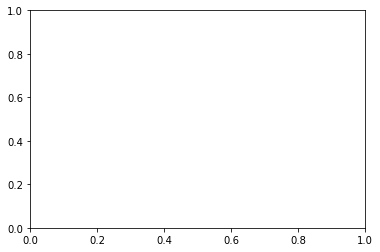

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
print(fig)
print(ax)

This simple figure just has some axes.  If we want to plot some data on it we can use the `.plot` method
on the `Axes` object (in this case it is an `AxesSubplot` object which is a subclass of `Axes`, which means
it inherits the same methods and attributes as `Axes`).

Lets start a new figure and plot our north measurements. We will use the `"times"` as our x-values.

Note, in all the following, the `_ =` is unnecessary, and marks an unused variable.  If you want to know
why it is there I can show you all, but it comes down to [continuously testing](https://circleci.com/gh/calum-chamberlain/ESCI451-Python) 
these notebooks to make sure they work.

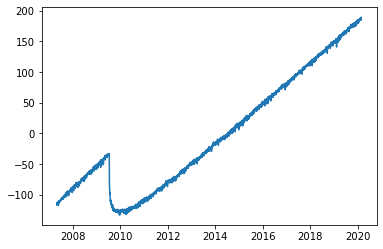

In [6]:
fig, ax = plt.subplots()
_ = ax.plot(pygr_data["time"], pygr_data["north"])

There's a big jump in it! Bonus points for the first one to shout-out what this is...

This graph is okay, but it doesn't have any labels! What are we plotting!? No-one will ever know.

Lets fix that...

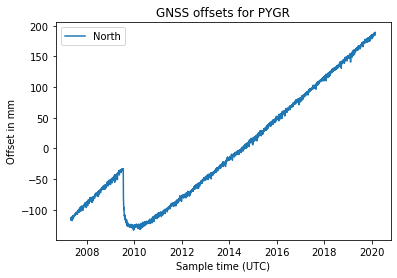

In [7]:
fig, ax = plt.subplots()
ax.plot(pygr_data["time"], pygr_data["north"], label="North")
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

So what did we do here?

1. We added a `label` argument to the call to plot, this
   attaches a `str` label to our data, our later call to
   `ax.legend()` used this label to make a legend;
2. We added a label to the x-axis using `ax.set_xlabel`
3. Similarly, we added a label to the y-axis using `ax.set_ylabel`
4. We added a useful title using `ax.set_title`
5. We added a legend - this comes in useful when plotting
   multiple data on the same graph...
   
Lets make use of that and plot all three components on the same graph:

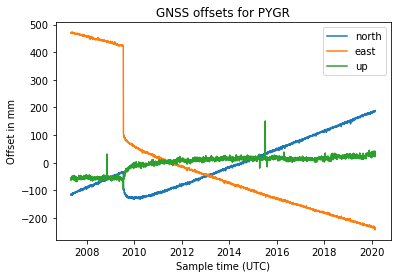

In [8]:
fig, ax = plt.subplots()
# We can automate this with a loop, yay! If you find youself 
# copy-and-pasting code you are missing the point of writing code!
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

The step shows up on all components! Who would have thought it...?

Matplotlib automatically plots each line in a different colour, which is great! But maybe you don't like the
default colours? We can specify colours, and loop through them as well if we want:

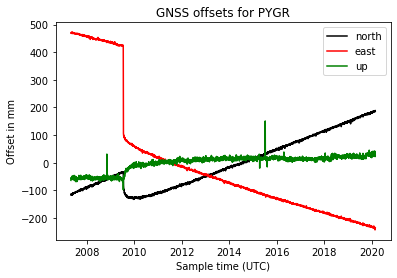

In [9]:
fig, ax = plt.subplots()
# Using the `zip` command we can iterate through pairs of lists.
for component, colour in zip(["north", "east", "up"], ["black", "red", "green"]):
    # We add the color keyword argumet to set the colour of the line.
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component, color=colour)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

You will note that matplotlib uses American (wrong) spelling.  You get used to it.

You can control all sorts of other style aspects of matplotlib, one of the simplest ways is to change
the stylesheet that matplotlib is using.  There are quite a few of them, with 
[examples here](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html).
I'm quite fond of "seaborn-dark", let's try that and let matplotlib work out the colours for us:

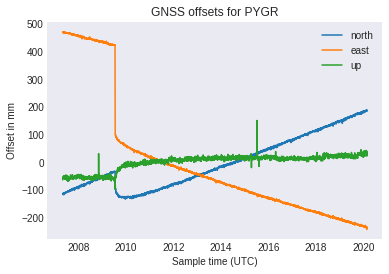

In [10]:
plt.style.use("seaborn-dark")
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

Nice.

**Exercise:** Using your knowledge of loops and if statements make a new dictionary with only the data between 2009-01-01 and 2011-01-01. Plot this:

In [11]:
# Your answer here:

An alternative way of plotting only a select region of data is to change the limits of the axes:

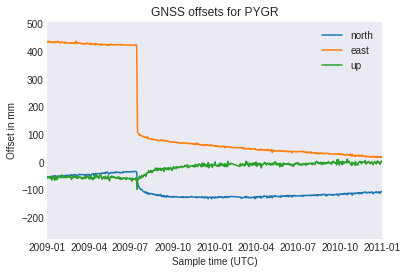

In [12]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

So far we have plotted data as a continuous line.  For continuous data like this, this is fine, but what if we want
to look at discrete samples?

In matplotlib you can make a scatter plot by specifying a marker (in this case we are using a **+** symbol),
and setting the `linestyle` to `"None"`. You can achieve the same result using `ax.scatter(x, y, marker="+")`,
but we will use the `.plot` method here because we need the arguments later...

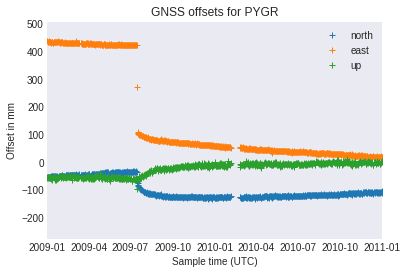

In [13]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            marker="+", linestyle="None",
            label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

We can immediately see that there is a gap in the data in early 2010 that wasn't obvious in our previous plots, which is helpful,
and a nice reminder than "continuous" data are not always as continuous as they seem.

The data that we are plotting are daily solutions of position relative to some reference point.  These daily solutions are
essentially averages (with quite a lot of extra noise reduction and weighting) of samples taken at much higher frequencies.
These positions are provided with error estimations: you should always plot your uncertainty to ensure you are not
over-interpreting features.  Lets plot some error bars on these points.

Remember those `marker` and `linestyle` arguments? We need them here as well.

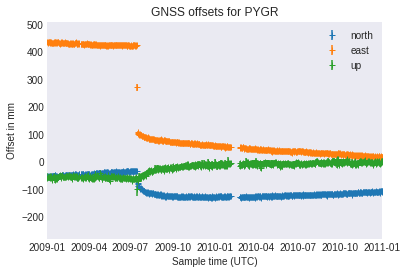

In [15]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.errorbar(pygr_data["time"], pygr_data[component], 
                yerr=pygr_data[f"{component}_error"],
                marker="+", linestyle="None",
                label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

They are plotted, but hard to see, lets plot just the vertical (up) component between 2009/06 and 2009/08:

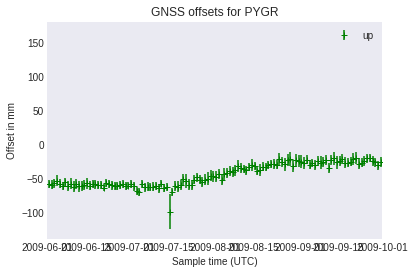

In [16]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"], 
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

This has kept the y-limits the same as for the whole dataset, meaning that we still can't see much! Let's adjust those
y limits in the same way that we adjusted the x-limits.

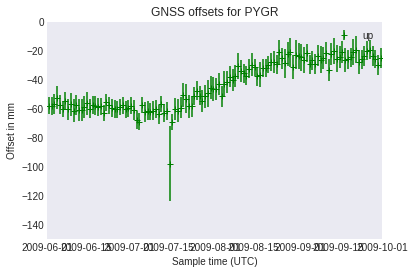

In [17]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"], 
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_ylim(-150, 0)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

Great, we can see that there is a large error for a particular point there.  For those who haven't guessed it yet, this is the
day of the [Dusky Sound earthquake](https://www.geonet.org.nz/earthquake/story/3124785). The errors are largest here because
the displacement is a) large and b) not instantaneous. There are components of co-seismic and post-seismic slip in this one
data-point that effectively smear the motion.  These daily GPS solutions are not *true* measurements, rather a model of the
displacements based on data. To use these data to model slip on faults, or other phenomena models are often built on top of
these daily solutions (models themselves).  If you don't understand the uncertainty in your data (whether those data are raw
data, or modeled data) you won't understand the uncertainty in your final result...

One last thing for now, our tick labels on the x-axis are overlapping, obscuring them from view. Lets sort that out as well:

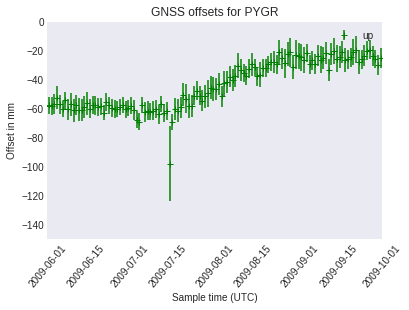

In [19]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"], 
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_ylim(-150, 0)
# Set the x-labels to be rotated so that they don't overlap.
plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
_ = ax.legend()

**Exercise:** Make a plot of the GNSS time-series for a station of your choosing.  
Look on the [GeoNet station search](https://www.geonet.org.nz/data/network/sensor/search) and tick the
GNSS/GPS box to show the GNSS stations.  Try and find one that you think will have some interesting signals.
Hint, find somewhere near a large earthquake, or close the Hikurangi margin where slow-slip regularly occurs.

In [20]:
# Your plots here.